# Import Data & Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
from ast import literal_eval
import konlpy
from collections import Counter
import time
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df_whole=pd.read_json('amore_data_detected_bert.json')
df_whole['review_split_string']=df_whole['review_split'].copy()
df_whole['review_split']=df_whole['review_split_string'].apply(literal_eval)
print(df_whole.shape)

(50183, 50)


In [3]:
df_whole['name']=df_whole[['brand','big_category','prod_nm']].agg('#'.join, axis=1)
df_whole['name_sub']=df_whole[['brand','big_category']].agg('#'.join, axis=1)

brand=list(set(df['brand']))
prod_name=list(set(df['name']))
prod_name_sub=list(set(df['name_sub']))

NameError: name 'df' is not defined

In [ ]:
df_whole.head(2)

# Functions

In [ ]:
def S1_number_func(x):
    return(sum([len(x[i].split(' ')) for i in range(len(x))]))

def S1_duplicate_func(x):
    return(len(set(x))/len(x))
    
def NVA(x):    
    total_words=[]
    for i, document in enumerate(list(set(x))):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): 
            if word[1] in ['Noun', 'Verb', 'Adjective']: 
                clean_words.append(word[0])
        total_words.append(clean_words)
    result = []
    for x in total_words:
        result.extend(x)
    return result


def S1_diversity_func(NVA):  
    return(len(set(NVA))/len(NVA))
    


def s1_recency_func(x,date):
    return((date-x.date()).days)

def S1_recency_func(x,max_date,window):
    """
    max=50 ( 50,49,,...1 )
    ----------------------------------------
    50,49,48,47,46 .... (max-0)~(max-window+1)
    49,48,47,46,45 .... (max-1)~(max-window+0)
    48,47,46,45,44 .... (max-2)~(max-window-1)
    ...
    5,4,3,2,1 ...,,,,,,. (max-45)~(max-window-44)
    ----------------------------------------
    max-45가 window가 될 때 까지
    """
    lower = max_date
    upper = max_date-window+1
    lower_sign=(x<=lower)
    upper_sign=(x>=upper)
    sign=lower_sign*upper_sign
    return sign

def s1_recency_list_func(prod_nm):
    tmp=S1_recency[S1_recency['prod_nm']==prod_nm]
    MA_list=[]
    for i in date_range:
        window_count = len(tmp['s1_recency'][tmp['s1_recency'].apply((lambda x: S1_recency_func(x,max_date-i,recency_window)))>0])
        window_count_mean = window_count/recency_window
        MA_list.append(window_count_mean)
    return MA_list

# CBS

각 요소는 0~1사이 값을 가지도록 구성한다

## 날짜 범위 설정

- 점수 계산 날짜 : (x)일
- 점수 계산 대상 날짜 : (x-14)일~ (x)일

In [15]:
def get_current_Kdays(df,current_Y,current_M,current_D,K=14):
    eval_date = datetime.date(current_Y,current_M,current_D)
    df['recency']=df['date'].apply((lambda x: s1_recency_func(x,eval_date)))
    return df[df['recency']<K]

In [16]:
df = get_current_Kdays(df_whole,2021,7,31,K=14)

In [17]:
df.shape

(1036, 53)

## (score 1) Prevalence

In [19]:
score1 = df['name'].value_counts()
score1 = score1/score1.max()

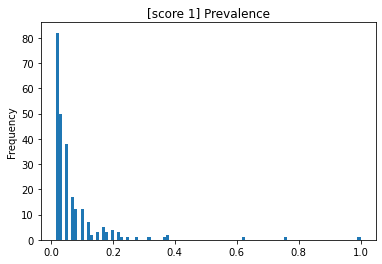

In [38]:
score1.plot(kind='hist',bins=100,title='[score 1] Prevalence')

## (score 2) Diversity

- nva : Noun + Verb + Adjective
- 소요 시간 : **0.04초/1개 리뷰**

In [86]:
nva=df['review_split'].apply(NVA)

In [28]:
df['diversity'] = nva.apply(S1_diversity_func)

<ipython-input-28-0a59c65ad644>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diversity'] = nva.apply(S1_diversity_func)


In [31]:
score2=df.groupby('name').mean()['diversity']

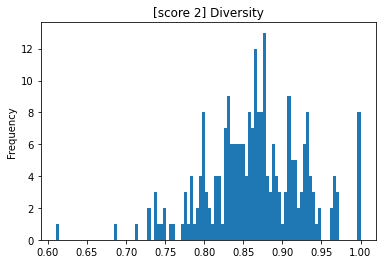

In [39]:
score2.plot(kind='hist',bins=100,title='[score 2] Diversity')

## (score 3) Connectivity

- connectivity의 network 구성에는 너무 많은 연산량이 소요된다.
- 많이 등장한 top K word만을 대상으로 네트워크를 구성한다
- (주의) 제품명 텍스트 (prod_name)은 반드시 포함해야!
- 모든 "review text"앞에 "브랜드#대제품군#제품명" 붙이기

In [444]:
def top_K_words(nva,prod_name_sub,K,thres=10,node='brand'):
    
    assert node in ['brand','brand+big','brand+big+prd']
    top_K=[]
    
    if node=='brand':
        tmp=list(df['brand'])
        top_K.extend(list(set(df['brand'])))
    elif node=='brand+big':
        tmp=list(df['name_sub'])
        top_K.extend(list(set(df['name_sub'])))
    else:
        tmp=list(df['name'])
        top_K.extend(list(set(df['name'])))
    
    nva_list=list(nva)
    for i in range(len(nva_list)):
        nva_list[i]=[tmp[i]]+nva_list[i]

    concat_list = np.concatenate(nva_list)

        
    cnt = Counter(concat_list)
    list_sorted = sorted(list(cnt.items()), key=lambda x: [-x[1], x[0]])
    
    nva_topK = []
    
    for i in range(2*K): 
        top_K.append(list_sorted[i][0])
    top_K = top_K[thres:K+thres]
    top_K = [word for word in top_K if len(word)>1]
    
    for idx in range(len(nva.index)):
        nva_topK.append([word for word in nva_list[idx] if word in top_K])

    before=len(np.concatenate(nva.values))
    after=len(np.concatenate(nva_topK))
    print(np.round(after/before,3)*100,'% 만큼의 단어 생존')
    
    return nva_topK

In [445]:
def get_coocmat(nva_topK):
    u = (pd.get_dummies(pd.DataFrame(nva_topK), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

    cooc_mat = u.T.dot(u)
    cooc_mat.values[(np.r_[:len(cooc_mat)], ) * 2] = 0
    return cooc_mat
    

In [468]:
def connectivity_from_cooc(coocurence_mat):
    cooc_mat = coocurence_mat.copy()
    print('shape of coocurrence matrix :',cooc_mat.shape)
    time1 = time.time()
    conn = cooc_mat.stack()
    conn=conn.rename_axis(('source','target')).reset_index(name='weight')
    G = nx.from_pandas_edgelist(conn,edge_attr=True)
    time2 = time.time()
    print('Constructing Graph took {} secs'.format(time2-time1))
    for u,v,data in G.edges(data=True):
        if 'weight' in data and data['weight']!=0:
            data['inverse']=1/data['weight']
        else:
            data['inverse']=1
    connectivity = nx.betweenness_centrality(G,normalized=False,weight='inverse',endpoints =True)
    time3 = time.time()
    print('Calculating Connectivity took {} secs'.format(time3-time2))
    return connectivity

In [449]:
# ['brand','brand+big','brand+big+prd']
nva_topK = top_K_words(nva,list(set(df['brand'])),K=300,thres=15,node='brand')
cooc_mat=get_coocmat(nva_topK)
connectivity_tmp = connectivity_from_cooc(cooc_mat)

tmp=[]
for b in brand:
    tmp.append(connectivity_tmp[b])
connectivity=tmp/max(np.array(tmp))

45.6 % 만큼의 단어 생존
shape of coocurrence matrix : (237, 237)
Constructing Graph took 0.1560349464416504 secs
Calculating Connectivity took 9.116677045822144 secs


In [455]:
connectivity_tmp

{'amore': 0.008438818565400845,
 'hanyul': 0.008581849388543231,
 'hera': 0.0357219480798112,
 'iope': 0.008438818565400845,
 'laneige': 0.010190946148895088,
 'mamonde': 0.0123006507902453,
 'primera': 0.008546091682757636,
 'sulhwasoo': 0.00847457627118644,
 '가격': 0.008438818565400845,
 '가다': 0.008438818565400845,
 '가볍다': 0.008438818565400845,
 '가장': 0.008438818565400845,
 '각질': 0.008438818565400845,
 '감다': 0.008438818565400845,
 '강하다': 0.008438818565400845,
 '개선': 0.008438818565400845,
 '거리': 0.008438818565400845,
 '거의': 0.008438818565400845,
 '거품': 0.008438818565400845,
 '걱정': 0.008438818565400845,
 '건성': 0.008438818565400845,
 '건조하다': 0.008438818565400845,
 '겨울': 0.008438818565400845,
 '계속': 0.008438818565400845,
 '고민': 0.008438818565400845,
 '괜찮다': 0.008438818565400845,
 '구매': 0.09089608810698706,
 '구입': 0.008438818565400845,
 '그냥': 0.008438818565400845,
 '그렇다': 0.008438818565400845,
 '기능': 0.008438818565400845,
 '기분': 0.008438818565400845,
 '기초': 0.008438818565400845,
 '꾸준하다': 0

In [453]:
connectivity

array([0.28528529, 0.23923924, 0.24024024, 0.34434434, 0.23623624,
       0.23623624, 0.23723724, 1.        ])

In [450]:
print('sparsity of cooccurence matrix :',np.round(sum(sum((cooc_mat==0).values))/(cooc_mat.shape[0]**2),4))

sparsity of cooccurence matrix : 0.2065
